#Imports

In [15]:
pip install -q pytorch-lightning

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torchmetrics import Accuracy
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/C147\ Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/Shareddrives/C147 Project'
/content/drive/Shareddrives/C147 Project


# Data Augmentations & Dataloaders

In [18]:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def augment(X, y, subject, subsample_size, average_size):
  X_total = None
  y_total = None
  subject_total = None
  # Maxpool
  X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, subsample_size), axis=3)
  X_total = X_max
  y_total = y
  subject_total = subject
  # Average
  X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average_size), axis=3)
  X_average += np.random.normal(0, 0.5, X_average.shape)
  X_total = np.vstack((X_total, X_average))
  y_total = np.vstack((y_total, y))
  subject_total = np.vstack((subject_total, subject))
  # Subsampling
  for i in range(subsample_size):
    X_subsample = X[:,:,i::subsample_size] + np.random.normal(0, 0.5, X[:,:,i::subsample_size].shape)
    X_total = np.vstack((X_total, X_subsample))
    y_total = np.vstack((y_total, y))
    subject_total = np.vstack((subject_total, subject))
  return X_total, y_total, subject_total

def prepare_dataset_augment(g, classIX=None, subjectIX=None, val_perc=0.05, time_window=512):
  X_test = np.load("project/X_test.npy")
  y_test = np.load("project/y_test.npy")
  person_test = np.load("project/person_test.npy")
  person_train_valid = np.load("project/person_train_valid.npy")
  X_train_valid = np.load("project/X_train_valid.npy")
  y_train_valid = np.load("project/y_train_valid.npy")

  ind_valid = np.random.choice(2115, int(2115*val_perc), replace=False)
  ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
  X_train = X_train_valid[ind_train]
  X_valid = X_train_valid[ind_valid]
  y_train = y_train_valid[ind_train]
  y_valid = y_train_valid[ind_valid]
  person_train = person_train_valid[ind_train]
  person_valid = person_train_valid[ind_valid]
    
  if not classIX is None:
    train_ind = np.where(y_valid-769==classIX)[0]
    valid_ind = np.where(y_valid-769==classIX)[0]
    test_ind = np.where(y_test-769==classIX)[0]
    
    X_test = X_test[test_ind]
    y_test = y_test[test_ind]
    person_test = person_test[test_ind]
    
    person_valid = person_valid[valid_ind]
    X_valid = X_valid[valid_ind]
    y_valid = y_valid[valid_ind]
    
    person_train = person_train[train_ind]
    X_train = X_train[train_ind]
    y_train = y_train[train_ind]
  if not subjectIX is None:
    train_ind = np.where(person_train==subjectIX)[0]
    X_train = X_train[train_ind]
    y_train = y_train[train_ind]
    person_train = person_train[train_ind]

    valid_ind = np.where(person_valid==subjectIX)[0]
    person_valid = person_valid[valid_ind]
    X_valid = X_valid[valid_ind]
    y_valid = y_valid[valid_ind]

    test_ind = np.where(person_test==subjectIX)[0]
    X_test = X_test[test_ind]
    y_test = y_test[test_ind]
    person_test = person_test[test_ind]

  train_b = y_train.shape[0]
  valid_b = y_valid.shape[0]
  test_b = y_test.shape[0]

  train_b = y_train.shape[0]
  y_train_onehot = np.zeros((train_b, 4))
  for IX in range(len(y_train)):
    class_IX = int(y_train[IX] - 769)
    y_train_onehot[IX, class_IX] = 1

  test_b = y_test.shape[0]
  y_test_onehot = np.zeros((test_b, 4))
  for IX in range(len(y_test)):
    class_IX = int(y_test[IX] - 769)
    y_test_onehot[IX, class_IX] = 1
    
  valid_b = y_valid.shape[0]
  y_valid_onehot = np.zeros((valid_b, 4))
  for IX in range(len(y_valid)):
    class_IX = int(y_valid[IX] - 769)
    y_valid_onehot[IX, class_IX] = 1

  person_train_onehot = np.zeros((train_b, 9))
  for IX in range(len(person_train)):
    class_IX = int(person_train[IX])
    person_train_onehot[IX, class_IX] = 1

  person_test_onehot = np.zeros((test_b, 9))
  for IX in range(len(person_test)):
    class_IX = int(person_test[IX])
    person_test_onehot[IX, class_IX] = 1
    
  person_valid_onehot = np.zeros((valid_b, 9))
  for IX in range(len(person_valid)):
    class_IX = int(person_valid[IX])
    person_valid_onehot[IX, class_IX] = 1

  # Augmentations
  X_train = X_train[:,:,0:time_window]
  X_valid = X_valid[:,:,0:time_window]
  X_test = X_test[:,:,0:time_window]
  X_train, y_train_onehot, person_train_onehot = augment(X_train, y_train_onehot, person_train_onehot, 2, 2)
  X_test, y_test_onehot, person_test_onehot = augment(X_test, y_test_onehot, person_test_onehot, 2, 2)
  X_valid, y_valid_onehot, person_valid_onehot = augment(X_valid, y_valid_onehot, person_valid_onehot, 2, 2)

  X_test_tensor = torch.Tensor(X_test)
  y_test_tensor = torch.Tensor(y_test_onehot)
  person_test_tensor = torch.Tensor(person_test_onehot)
  person_valid_tensor = torch.Tensor(person_valid_onehot)
  X_valid_tensor = torch.Tensor(X_valid)
  y_valid_tensor = torch.Tensor(y_valid_onehot)
  person_train_tensor = torch.Tensor(person_train_onehot)
  X_train_tensor = torch.Tensor(X_train)
  y_train_tensor = torch.Tensor(y_train_onehot)

  train_dataset = TensorDataset(X_train_tensor, y_train_tensor, person_train_tensor)
  valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor, person_valid_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor, person_test_tensor)
  train_trials = X_train.shape[0]
  valid_trials = X_valid.shape[0]

  train_dataloader = DataLoader(train_dataset, batch_size=int(train_trials*0.25), pin_memory=True, worker_init_fn=seed_worker, generator=g)
  valid_dataloader = DataLoader(valid_dataset, batch_size=valid_trials, pin_memory=True, worker_init_fn=seed_worker, generator=g)
  test_dataloader = DataLoader(test_dataset, batch_size=valid_trials, worker_init_fn=seed_worker, generator=g)

  return train_dataloader, valid_dataloader, test_dataloader

# Section

In [29]:
torch.use_deterministic_algorithms(True, warn_only=True)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=None,
    filename="best_val-{epoch:02d}-{val_loss:.2f}")

def train_aug(model_name, model, seed):
  pl.seed_everything(seed, workers=True)
  g = torch.Generator()
  g.manual_seed(seed)
  train_dataloader, validation_dataloader, test_dataloader = prepare_dataset_augment(g, time_window=512)
  early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=1000)
  logger = pl.loggers.TensorBoardLogger('official_logs', name=model_name)
  trainer = pl.Trainer(max_epochs=500, logger=logger, 
                       callbacks= [early_stopping_callback, checkpoint_callback, StochasticWeightAveraging(swa_lrs=7e-4, swa_epoch_start=160)],
                       accelerator="gpu", devices=1, deterministic=True, 
                       gradient_clip_val=2, accumulate_grad_batches=4) 
  trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)
  return g, trainer, model, test_dataloader

from models.CNN import *
model_name = "CNN w aug and FFT"
learning_rate = 1e-3
model = CNN_FFT(naive=True, end = False, lr=learning_rate, time_window=256)
g, trainer, model, test_dataloader = train_aug(model_name, model, 40)

INFO:lightning_fabric.utilities.seed:Global seed set to 40
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type               | Params
-------------------------------------------------
0  | accuracy | MulticlassAccuracy | 0     
1  | conv1    | Conv1d             | 7.1 K 
2  | swish1   | ELU                | 0     
3  | maxpool1 | MaxPool1d          | 0     
4  | bn1      | BatchNorm1d        | 64    
5  | dropout1 | Dropout            | 0     
6  | conv2    | Conv1d             | 20.5 K
7  | swish2   | ELU                | 0     
8  | maxpool2 | MaxPool1d          | 0  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=501` reached.


In [28]:
overall = trainer.test(model, dataloaders=test_dataloader, verbose=True)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7042889595031738
        test_loss            1.053000807762146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [30]:
test_acc = []
for subjectIX in range(0,9):
  _, _, test_dataloader_IX = prepare_dataset_augment(g, subjectIX=subjectIX)
  tested = trainer.test(model, dataloaders=test_dataloader_IX, ckpt_path="best", verbose=False)
  tested = tested[0]['test_accuracy']
  test_acc.append(tested)
  print("Subject " + str(subjectIX) + " Test Accuracy: " + str(tested))
  print()

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 0 Test Accuracy: 0.6499999761581421



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 1 Test Accuracy: 0.5600000023841858



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 2 Test Accuracy: 0.7250000238418579



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 3 Test Accuracy: 0.6499999761581421



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 4 Test Accuracy: 0.792553186416626



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 5 Test Accuracy: 0.6377550959587097



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 6 Test Accuracy: 0.7149999737739563



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 7 Test Accuracy: 0.6549999713897705



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at official_logs/CNN w aug and FFT/version_10/checkpoints/best_val-epoch=97-val_loss=0.65.ckpt


Testing: 0it [00:00, ?it/s]

Subject 8 Test Accuracy: 0.7872340679168701



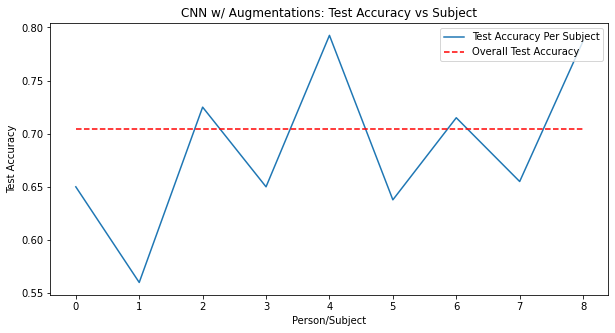

In [31]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(0,9), test_acc, label="Test Accuracy Per Subject")
plt.plot(np.arange(0,9), np.repeat(overall[0]['test_accuracy'], 9), 'r--', label="Overall Test Accuracy")
plt.legend(loc="upper right")
plt.xlabel("Person/Subject")
plt.ylabel("Test Accuracy")
plt.title("CNN w/ Augmentations: Test Accuracy vs Subject")
plt.show()